In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
import keras_tuner as kt
import numpy as np

import kaggle_functions as kaggle
import importlib
importlib.reload(kaggle);

model_number = 'model6'

In [2]:
# Create datasets
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()

batch_size = 128
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

### VGG-style simple CNN (custom)

In [3]:
class VGG(kt.HyperModel):
    def conv_layer(self, input, filters, stride=1, kernel=3, l2_reg=0, padding='same'):
        return layers.Conv2D(
            filters, kernel_size=(kernel,kernel), strides=(stride,stride), 
            padding=padding, activation='relu',
            kernel_regularizer=reg.l2(l2_reg), bias_regularizer=reg.l2(l2_reg),
            kernel_initializer='he_uniform')(input)

    def build(self, hyperparameters):
        # Tunable hyperparameters
        if hyperparameters is not None: 
            dense_l2_reg = hyperparameters.Choice('dense_l2_reg', [0.0, 0.00001, 0.0001, 0.001])
            dense_dropout = hyperparameters.Float('dense_dropout', 0.1, 0.5, step=0.1)
        else:
            dense_l2_reg = 0.001
            dense_dropout = 0.3

        # Fixed hyperparameters
        learning_rate = 0.0005

        input_layer = layers.Input(shape=(96, 96, 1))

        output = self.conv_layer(input_layer, 32, stride=2)
        output = self.conv_layer(output, 32)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 64, stride=2)
        output = self.conv_layer(output, 64)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 128, stride=2)
        output = self.conv_layer(output, 128)
        output = layers.BatchNormalization()(output)
        output = self.conv_layer(output, 256, stride=2)
        output = self.conv_layer(output, 256)
        output = layers.BatchNormalization()(output)

        # Final output
        output = layers.Flatten()(output)
        output = layers.Dropout(dense_dropout / 2)(output)
        output = layers.Dense(
            128, activation='relu', kernel_initializer='he_uniform',
            kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)
        output = layers.Dropout(dense_dropout)(output) 
        output = layers.Dense(
            11, kernel_regularizer=keras.regularizers.l2(dense_l2_reg),
            bias_regularizer=keras.regularizers.l2(dense_l2_reg))(output)

        model = keras.models.Model(inputs=input_layer, outputs=output)

        # Create model
        model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

        return model

# VGG().build(None).summary()

In [ ]:
# Hyperparameter tuning
# Use RandomSearch to check Choice params, or Bayesian for Float/Ints
# Took 3hrs for 8 trials with 200 epochs

reload_tuner = True
tuner_filepath = 'hypertuner_2021-11-26'

tuner_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)
]

tuner = kt.RandomSearch(VGG(),
    objective='val_accuracy',
    max_trials=8,
    seed=1,
    directory=f'models/{model_number}',
    project_name=tuner_filepath,
    overwrite=(not reload_tuner))

# tuner.search_space_summary()

if reload_tuner:
    tuner.reload()
else:
    tuner.search(
        train_dataset_augmented, 
        validation_data=valid_dataset.batch(128).cache(),
        epochs=200, steps_per_epoch=epoch_length,
        callbacks=tuner_callbacks, verbose=1)

tuner.results_summary()

# model = tuner.get_best_models(2)[1]

In [ ]:
# Fit model 
print('Building new model')
model, history = kaggle.train_model(
    VGG().build(None), train_dataset_augmented, valid_dataset, 
    epochs=200, valid_patience=30, epoch_length=epoch_length)

In [ ]:
# Save model
model_name = 'VGG_5'
model.save(f'models/{model_number}/VGG_5')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

In [6]:
# Fine-tune model
print('Fine-tuning model')
fine_model, history = kaggle.fine_tune_model_filepath(
    f'models/{model_number}/VGG_6_80', 
    train_dataset.batch(128).cache(), valid_dataset, 
    epochs=5, learning_rate=0.0001)

Fine-tuning model
75/75 [==============================] - 22s 263ms/step - loss: 0.2370 - accuracy: 0.9259 - val_loss: 0.7726 - val_accuracy: 0.7977


In [13]:
# Save fine-tuned model
fine_model.save(f'models/{model_number}/VGG_7_nn')

INFO:tensorflow:Assets written to: models/model6/VGG_6_80\assets


### Evaluate model

Accuracy: 0.7981


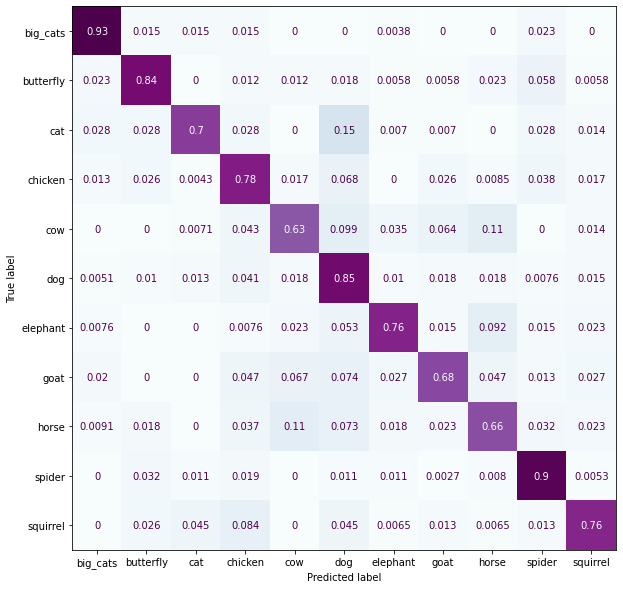

In [4]:
model_to_evaluate = 'VGG_6_79' # Can be changed to evaluate older models
try:
    loaded_model = keras.models.load_model(f'models/{model_number}/{model_to_evaluate}')
except:
    loaded_model = model

test_pred_raw = loaded_model.predict(valid_dataset.batch(128))
test_pred = np.argmax(test_pred_raw, axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)